In [1]:
from datetime import date
import pandas as pd
import re
import requests

## Pull data

In [2]:
url = "https://www.lib.ncsu.edu/api/workshops/all"

In [3]:
r = requests.get(url)
r

<Response [200]>

In [4]:
data = r.json()

In [5]:
data[0]

{'title': 'IRB Basics: eIRB Application Workshop',
 'nid': '57007',
 'field_time_d8': '01-20-2021 10:00AM to 01-20-2021 1:00PM',
 'body': '<p><span><span>This workshop provides an overview of how to write your eIRB application and is designed for first-time IRB application filers and NC State students who want to participate in the </span><a href="https://research.ncsu.edu/administration/compliance/research-compliance/irb/irb-for-researchers/priority-review-process/">Priority Review Process</a><span> (PRP) program. Faculty and staff are welcome to attend this workshop provided that the prerequisites are completed; participation in the PRP program is, however, limited to students only at this time. All workshop attendees must complete the below online training, which has no cost to NC State University affiliates with valid Unity IDs and passwords. To access CITI training, please consult the </span><a href="https://drive.google.com/file/d/15On0UevTEaZz9cXk9pVPdSstZPFgjnbO/view">CITI trai

In [6]:
df = pd.DataFrame(data)
df.head()

,title,nid,field_time_d8,body,field_registration_url,field_non_library_instructor,field_workshop_leads_export,field_workshop_series,field_workshop_user_activities,field_non_libraries_space_1,field_space
0,IRB Basics: eIRB Application Workshop,57007,01-20-2021 10:00AM to 01-20-2021 1:00PM,<p><span><span>This workshop provides an overv...,"<a href=""https://reporter.ncsu.edu/link/instan...",\nYael Allen\n\n,[],Research Strategy,,Online only,
1,Campus Conversations Project: Inauguration Day...,57129,01-20-2021 7:00PM to 01-20-2021 8:30PM,<p>Trained student volunteers from the <a href...,"<a href=""https://reporter.ncsu.edu/link/instan...",\nMorgan DiCarlo\n\n,"[{'id': '279', 'url': 'https://www.lib.ncsu.ed...",,,Online only,
2,IRB Basics Part II: Handling Your Data and Ass...,57017,01-21-2021 1:00PM to 01-21-2021 4:00PM,<p><span>This workshop builds upon the IRB Bas...,"<a href=""https://reporter.ncsu.edu/link/instan...",\nYael Allen\n\n,[],,,Online only,
3,IRB Topical Workshop: IRB Process and IT Profe...,57103,01-21-2021 3:00PM to 01-21-2021 5:00PM,<p>This session is specifically for IT profess...,"<a href=""https://reporter.ncsu.edu/link/instan...",,[],,Grants &amp; Funding,Online only,
4,IRB Topical Workshop: Using “Apps” and other S...,56995,01-25-2021 10:00AM to 01-25-2021 12:00PM,<p>This session will discuss the use of “off t...,"<a href=""https://reporter.ncsu.edu/link/instan...",,[],,Grants &amp; Funding,Online only,


Strip white spaces from the `field_non_library_instructor` column. 

In [7]:
df["field_non_library_instructor"] = df["field_non_library_instructor"].str.strip()
df.head()

,title,nid,field_time_d8,body,field_registration_url,field_non_library_instructor,field_workshop_leads_export,field_workshop_series,field_workshop_user_activities,field_non_libraries_space_1,field_space
0,IRB Basics: eIRB Application Workshop,57007,01-20-2021 10:00AM to 01-20-2021 1:00PM,<p><span><span>This workshop provides an overv...,"<a href=""https://reporter.ncsu.edu/link/instan...",Yael Allen,[],Research Strategy,,Online only,
1,Campus Conversations Project: Inauguration Day...,57129,01-20-2021 7:00PM to 01-20-2021 8:30PM,<p>Trained student volunteers from the <a href...,"<a href=""https://reporter.ncsu.edu/link/instan...",Morgan DiCarlo,"[{'id': '279', 'url': 'https://www.lib.ncsu.ed...",,,Online only,
2,IRB Basics Part II: Handling Your Data and Ass...,57017,01-21-2021 1:00PM to 01-21-2021 4:00PM,<p><span>This workshop builds upon the IRB Bas...,"<a href=""https://reporter.ncsu.edu/link/instan...",Yael Allen,[],,,Online only,
3,IRB Topical Workshop: IRB Process and IT Profe...,57103,01-21-2021 3:00PM to 01-21-2021 5:00PM,<p>This session is specifically for IT profess...,"<a href=""https://reporter.ncsu.edu/link/instan...",,[],,Grants &amp; Funding,Online only,
4,IRB Topical Workshop: Using “Apps” and other S...,56995,01-25-2021 10:00AM to 01-25-2021 12:00PM,<p>This session will discuss the use of “off t...,"<a href=""https://reporter.ncsu.edu/link/instan...",,[],,Grants &amp; Funding,Online only,


Remove HTML tags from `body`.

In [8]:
def strip_html_tags(text: str) -> str:
    tag = re.compile("<.*?>")
    return re.sub(tag, "", text)


In [9]:
df["body"] = df["body"].apply(strip_html_tags)
df.head()

,title,nid,field_time_d8,body,field_registration_url,field_non_library_instructor,field_workshop_leads_export,field_workshop_series,field_workshop_user_activities,field_non_libraries_space_1,field_space
0,IRB Basics: eIRB Application Workshop,57007,01-20-2021 10:00AM to 01-20-2021 1:00PM,This workshop provides an overview of how to w...,"<a href=""https://reporter.ncsu.edu/link/instan...",Yael Allen,[],Research Strategy,,Online only,
1,Campus Conversations Project: Inauguration Day...,57129,01-20-2021 7:00PM to 01-20-2021 8:30PM,Trained student volunteers from the Campus Con...,"<a href=""https://reporter.ncsu.edu/link/instan...",Morgan DiCarlo,"[{'id': '279', 'url': 'https://www.lib.ncsu.ed...",,,Online only,
2,IRB Basics Part II: Handling Your Data and Ass...,57017,01-21-2021 1:00PM to 01-21-2021 4:00PM,This workshop builds upon the IRB Basics: Part...,"<a href=""https://reporter.ncsu.edu/link/instan...",Yael Allen,[],,,Online only,
3,IRB Topical Workshop: IRB Process and IT Profe...,57103,01-21-2021 3:00PM to 01-21-2021 5:00PM,This session is specifically for IT profession...,"<a href=""https://reporter.ncsu.edu/link/instan...",,[],,Grants &amp; Funding,Online only,
4,IRB Topical Workshop: Using “Apps” and other S...,56995,01-25-2021 10:00AM to 01-25-2021 12:00PM,This session will discuss the use of “off the ...,"<a href=""https://reporter.ncsu.edu/link/instan...",,[],,Grants &amp; Funding,Online only,


Write to csv, with date.

In [10]:
df.to_csv(f"current-workshops-{date.today()}.csv")

## Explore text

TODO:
- Consistency across workshops
    - Length of description
    - Consistent keywords?
    - Does title reflect body paragraph? (check keywords)
        - Does body contain words from the title? Does title contain words from body?
    - Consistency of workshop descriptions across related titles
        - If we have multiple introductions to python, are the descriptions similar?
        - Similar across intro to R vs intro python? 
- Lexical variety?


In [2]:
from nltk import word_tokenize
import numpy as np
import spacy

Read in the most current csv of workshop data. We'll hardcode it for now, but could always parse the filenames, and get the most recent. 

In [3]:
df = pd.read_csv("current-workshops-2021-01-20.csv")

In [4]:
def naive_count_words(text: str) -> int:
    return len([word for word in word_tokenize(text)
        if word not in [".", ",", "?", "'", "\"", ":", ";"]])

In [5]:
naive_count_words(df["body"][0])

296

We've done a naive pass to check word count minus punctuation. Let's compare it to spaCy's parsing, removing punctuation and spaces/newlines.

In [6]:
nlp = spacy.load("en_core_web_lg")

In [7]:
def spacy_count_words(text: str) -> int:
    doc = nlp(text)
    no_punct = [t for t in doc if t.is_punct == False]
    no_space = [t for t in no_punct if t.is_space == False]
    return len(no_space) 

In [8]:
spacy_count_words(df["body"][0])

289

Create a new column in the dataframe that contains number of words in the description(`body`).

In [9]:
df["body_word_count"] = df["body"].apply(spacy_count_words)

In [10]:
df.head()

,Unnamed: 0,title,nid,field_time_d8,body,field_registration_url,field_non_library_instructor,field_workshop_leads_export,field_workshop_series,field_workshop_user_activities,field_non_libraries_space_1,field_space,body_word_count
0,0,IRB Basics: eIRB Application Workshop,57007,01-20-2021 10:00AM to 01-20-2021 1:00PM,This workshop provides an overview of how to w...,"<a href=""https://reporter.ncsu.edu/link/instan...",Yael Allen,[],Research Strategy,NaN,Online only,NaN,289
1,1,Campus Conversations Project: Inauguration Day...,57129,01-20-2021 7:00PM to 01-20-2021 8:30PM,Trained student volunteers from the Campus Con...,"<a href=""https://reporter.ncsu.edu/link/instan...",Morgan DiCarlo,"[{'id': '279', 'url': 'https://www.lib.ncsu.ed...",NaN,NaN,Online only,NaN,115
2,2,IRB Basics Part II: Handling Your Data and Ass...,57017,01-21-2021 1:00PM to 01-21-2021 4:00PM,This workshop builds upon the IRB Basics: Part...,"<a href=""https://reporter.ncsu.edu/link/instan...",Yael Allen,[],NaN,NaN,Online only,NaN,71
3,3,IRB Topical Workshop: IRB Process and IT Profe...,57103,01-21-2021 3:00PM to 01-21-2021 5:00PM,This session is specifically for IT profession...,"<a href=""https://reporter.ncsu.edu/link/instan...",NaN,[],NaN,Grants &amp; Funding,Online only,NaN,144
4,4,IRB Topical Workshop: Using “Apps” and other S...,56995,01-25-2021 10:00AM to 01-25-2021 12:00PM,This session will discuss the use of “off the ...,"<a href=""https://reporter.ncsu.edu/link/instan...",NaN,[],NaN,Grants &amp; Funding,Online only,NaN,172


In [11]:
avg_word_count = np.mean(df["body_word_count"])
avg_word_count

123.44318181818181

In [12]:
lowest_word_count = df["body_word_count"].min()
lowest_word_count

36

In [13]:
highest_word_count = df["body_word_count"].max()
highest_word_count

289

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

<AxesSubplot:>

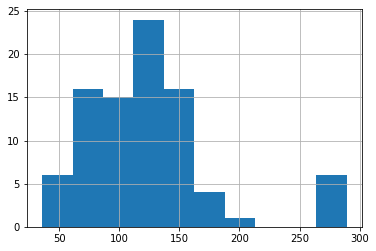

In [45]:
# Histogram of word counts to see distribution
df["body_word_count"].hist()

Let's figure out the most common words across the current future workshops. 

In [14]:
from collections import Counter
import textacy

In [15]:
corpus = textacy.Corpus(nlp, df["body"].to_list())
corpus

In [16]:
corpus.n_docs

88

In [19]:
corpus.n_tokens

12616

In [21]:
counts = corpus.word_counts(as_strings=True)

In [22]:
sorted(counts.items(), key=lambda x: x[1], reverse=True)[:20]

[('-PRON-', 347),
 ('IRB', 140),
 ('workshop', 134),
 ('research', 130),
 ('use', 120),
 ('datum', 102),
 ('session', 81),
 ('participant', 76),
 ('design', 73),
 ('researcher', 71),
 ('provide', 57),
 ('NC', 57),
 ('State', 57),
 ('learn', 50),
 ('application', 48),
 ('training', 47),
 ('software', 46),
 ('Research', 44),
 ('concept', 37),
 ('time', 36)]

In [25]:
counts["Python"]

14

In [27]:
counts["data"]

22

How much of this is a result of some descriptions being substantially longer than others?

TODO: check for how many workshops these commonly used terms appear in. 

In [38]:
def check_inclusion_nums(token, corpus):
    count = 0
    for doc in corpus:
        if token in [token.text for token in doc]:
            count += 1
    return count

In [39]:
check_inclusion_nums("IRB", corpus)

37

TODO: Write a function that takes a term and a corpus, and returns all the docs that have that term

Check to see if textacy already has this...

Generate keywords for each description

In [51]:
import textacy.ke
from itertools import chain

In [56]:
textacy.ke.sgrank(corpus[0])

[('CITI training tutorial', 0.2894638743311878),
 ('NC State', 0.1038538779913235),
 ('IRB application', 0.06673761015657964),
 ('workshop', 0.06518850818270899),
 ('PRP program', 0.04846851417291712),
 ('online training', 0.041306637085671435),
 ('business hour', 0.03237607045929546),
 ('research design', 0.016787663978917275),
 ('time', 0.009633394838772081),
 ('student', 0.00901539061123477)]

In [62]:
def get_keywords(text, spacy_model):
    doc = spacy_model(text)
    key_tuples = textacy.ke.sgrank(doc)
    return [k for k, _ in key_tuples]

In [63]:
df["keywords"] = df["body"].apply(get_keywords, spacy_model=nlp)

In [64]:
df.head()

,Unnamed: 0,title,nid,field_time_d8,body,field_registration_url,field_non_library_instructor,field_workshop_leads_export,field_workshop_series,field_workshop_user_activities,field_non_libraries_space_1,field_space,body_word_count,keywords
0,0,IRB Basics: eIRB Application Workshop,57007,01-20-2021 10:00AM to 01-20-2021 1:00PM,This workshop provides an overview of how to w...,"<a href=""https://reporter.ncsu.edu/link/instan...",Yael Allen,[],Research Strategy,NaN,Online only,NaN,289,"[CITI training tutorial, NC State, IRB applica..."
1,1,Campus Conversations Project: Inauguration Day...,57129,01-20-2021 7:00PM to 01-20-2021 8:30PM,Trained student volunteers from the Campus Con...,"<a href=""https://reporter.ncsu.edu/link/instan...",Morgan DiCarlo,"[{'id': '279', 'url': 'https://www.lib.ncsu.ed...",NaN,NaN,Online only,NaN,115,"[current NC State student, Campus Conversation..."
2,2,IRB Basics Part II: Handling Your Data and Ass...,57017,01-21-2021 1:00PM to 01-21-2021 4:00PM,This workshop builds upon the IRB Basics: Part...,"<a href=""https://reporter.ncsu.edu/link/instan...",Yael Allen,[],NaN,NaN,Online only,NaN,71,"[IRB Basics, NC State IRB application, additio..."
3,3,IRB Topical Workshop: IRB Process and IT Profe...,57103,01-21-2021 3:00PM to 01-21-2021 5:00PM,This session is specifically for IT profession...,"<a href=""https://reporter.ncsu.edu/link/instan...",NaN,[],NaN,Grants &amp; Funding,Online only,NaN,144,"[NC State University, NC State University rese..."
4,4,IRB Topical Workshop: Using “Apps” and other S...,56995,01-25-2021 10:00AM to 01-25-2021 12:00PM,This session will discuss the use of “off the ...,"<a href=""https://reporter.ncsu.edu/link/instan...",NaN,[],NaN,Grants &amp; Funding,Online only,NaN,172,"[software datum security, app, Discussion end ..."


In [65]:
df.to_csv("current-workshops-anno.csv")

In [69]:
for i in range(len(df["title"])):
    print(df["title"][i], "--", df["keywords"][i])

nding', 'measurement', 'restriction', 'participant']
IRB Topical Workshop: When Research Overlaps with Normal Education Practices -- ['Evaluation training session', 'generalizable knowledge conversation', 'Action Research', 'educational session', 'educational setting', 'research', 'educational practice', 'research project', 'IRB application', 'multiple role']
Campus Conversations Project: Inauguration Day: Transitions of Power -- ['current NC State student', 'Campus Conversation Project', 'student volunteer', 'presidential inauguration', 'prior preparation', 'different thing', 'people', 'core value', 'partisan division', 'question']
Innovation 101 -- ['innovation', 'global case study', 'workshop', 'different type', 'unintended consequence', 'prior knowledge', 'creative problem', 'question', 'local', 'future']
Citation Management with RefWorks -- ['RefWorks folder system', 'citation management software', 'major library database', 'appropriate citation style', 'citation manager', 'NCSU L